# Dirichlet process mixture models

[Bayesian mixture models](bayesian_mixture_models.ipynb) introduced how to infer the posterior of the parameters of a mixture model with a fixed number of components $K$. We can either find $K$ using model selection, i.e. with AIC, BIC, WAIC, etc., or try to automatically infer this number. Nonparametric mixture models do exactly this. 

Here we implement a nonparametric Bayesian mixture model using *Gibbs sampling*. We use a *Chinese restaurant process* prior and stick-breaking construction to sample from a *Dirichlet process* (see for instance Nils Hjort's [*Bayesian Nonparametrics*](https://www.cambridge.org/ch/academic/subjects/statistics-probability/statistical-theory-and-methods/bayesian-nonparametrics?format=HB&isbn=9780521513463), Peter Orbanz' [lecture notes](http://stat.columbia.edu/~porbanz/papers/porbanz_BNP_draft.pdf)), Kevin Murphy's [book](https://mitpress.mit.edu/books/machine-learning-1) and last but not least Herman Kamper's [notes](https://www.kamperh.com/notes/kamper_bayesgmm13.pdf). 

We'll implement the Gibbs sampler using the CRP ourselves, since (I think) Stan doesn't allow us to do this and then use the stick-breaking construction with Stan. That is technically not possible though, so we use a small hack.

**As usual I do not take warranty for the correctness or completeness of this document.**

In [Bayesian mixture models](bayesian_mixture_models.ipynb) we used following hierarchical form to describe a mixture model:

\begin{align*}
\boldsymbol \theta_k & \sim \mathcal{G}_0\\
\boldsymbol \pi &  \sim \text{Dirichlet}(\boldsymbol \alpha_0)\\
z_i &  \sim \text{Discrete}(\boldsymbol \pi)\\
\mathbf{x}_i \mid z_n = k &  \sim {P}(\boldsymbol \theta_k)
\end{align*}

where $\mathcal{G}_0$ is some base distribution for the model parameters.

The DP on contrast, as any BNP model, puts priors on structures that accomodate infinite sizes. The resulting posteriors give a distribution on structures that grow with new observations. A mixture model using an possibly infinite number of components could look like this:

\begin{align*}
\mathcal{G} & \sim \mathcal{DP}(\alpha, \mathcal{G}_0)\\
\boldsymbol \theta_i  & \sim \mathcal{G}\\
\mathbf{x}_i&  \sim {P}(\boldsymbol \theta_i)
\end{align*}

where $\mathcal{G}_0$ is the same base measure as above and $\mathcal{G}$ is a sample from the DP, i.e. also a random measure.

## The Chinese restaurant process

One way, and possibly the easiest, to implement a DPMM is using a *Chinese restaurant process* (CRP) which is a distribution over partitions. We will first discuss how a CRP creates the data and then build a Gibbs sampler to infer the parameters of a Gaussian DPMM.

### Data generating process

The hierarchical model using a CRP is:

\begin{align*}
\boldsymbol \theta_k & \sim \mathcal{G}_0 \\
z_i \mid \mathbf{z}_{1:i-1} & \sim \text{CRP} \\
\mathbf{x}_i & \sim P(\boldsymbol \theta_{z_i})
\end{align*}

where $\text{CRP}$ is a prior on possible infinitely many classes. Specifically the CRP is defined as:

\begin{align*}
P(z_i = k \mid \mathbf{z}_{-i}) = \left\{
                \begin{array}{ll}
                  \frac{N_k}{N - 1 + \alpha}\\
                  \frac{\alpha}{N - 1 + \alpha}\\
                \end{array}
              \right.
\end{align*}

where $N_k$ is the number of customers at table $k$ and $\alpha$ some hyperparameter.

For the variables of interest, $\boldsymbol  \theta_k$ and $\boldsymbol z$ the posterior is:

\begin{align*}
P(\boldsymbol \theta, \boldsymbol z \mid \mathbf{X}) \propto P(\mathbf{X} \mid \boldsymbol \theta, \boldsymbol z ) P(\boldsymbol \theta) P ( \boldsymbol z )
\end{align*}

In the Gaussian case the hierarchical model above has the following form:

\begin{align*}
\boldsymbol \Sigma_k & \sim \mathcal{IW}\\
\boldsymbol \mu_k & \sim \mathcal{N}(\boldsymbol \mu_0, \boldsymbol \Sigma_0) \\
z_i \mid z_{1:i-1} & \sim \text{CRP} \\
\mathbf{x}_i & \sim \mathcal{N}(\boldsymbol \mu_{z_i}, \boldsymbol \Sigma_{z_i})
\end{align*}

Using a Gibbs sampler, we iterate over the following three steps:

1) sample $z_i \sim P(z_i \mid \mathbf{z}_{-i}, \mathbf{X}, \boldsymbol \theta) \propto P(z_i \mid \mathbf{z}_{-i}) P(\mathbf{x}_i \mid \boldsymbol \theta_{z_i})$

2) sample $\boldsymbol \theta_k \sim P(\boldsymbol \theta_k \mid \mathbf{z}, \mathbf{X})$

So we alternate sampling assignments of data to classes and sampling the parameters of a normal distribution given the class assignments. The major difference here compared to the finite case is the way of sampling $z_i$ which we do using the CRP in the infinite case.

In [1]:
options(repr.fig.width=4, repr.plot.height=3)

In [2]:
suppressMessages(library("e1071"))
suppressMessages(library("mvtnorm"))
suppressMessages(library("dplyr"))
suppressMessages(library("ggplot2"))
suppressMessages(library("MCMCpack"))
suppressMessages(library("rlang"))
set.seed(23)

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

First we set data $\mathbf{X}$ some constants. We create a very simple data set to avoid problems with identifiability and label switching. For a treatment of the topic see Michael Betancourt's [case study](https://betanalpha.github.io/assets/case_studies/identifying_mixture_models.html).

In [3]:
n <- 100
p <- 2
alpha <- .5

Latent class assignments (`Z`), the current table index and the number of customers per table.

In [4]:
Z <- integer(n)
X <- matrix(0, n, p)
curr.tab <- 0
tables <- c()

In [5]:
sigma <- .1
mus <- NULL

Then we create a random assignment of customers to tables with probability $P(z_i \mid Z_{-i})$, i.e. we use the CRP to put data into classes.
Note that we don't know the number of classes that comes out!

In [6]:
for (i in seq(n))
{   
    probs <- c(tables / (i - 1 + alpha), alpha / (i - 1 + alpha))
    table <- rdiscrete(1, probs)
    if (table > curr.tab) 
    {
        curr.tab <- curr.tab + 1
        tables <- c(tables, 0)
        mu <- mvtnorm::rmvnorm(1, c(0, 0), 10 * diag(p))
        mus <- rbind(mus, mu)
    }
    Z[i] <- table
    X[i,] <- mvtnorm::rmvnorm(1, mus[Z[i], ], sigma * diag(p))
    tables[table] <-  tables[table] + 1
}

Let's see how many clusters and how many data points per clusters we have.

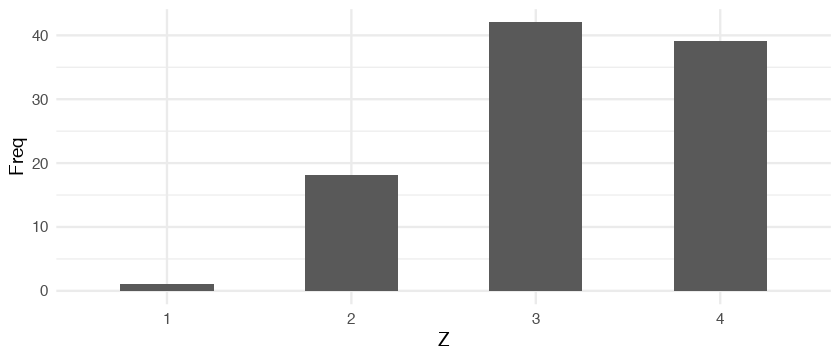

In [7]:
data.frame(table(Z))%>%
    ggplot() +
    geom_col(aes(Z, Freq), width=.5) +
    theme_minimal()

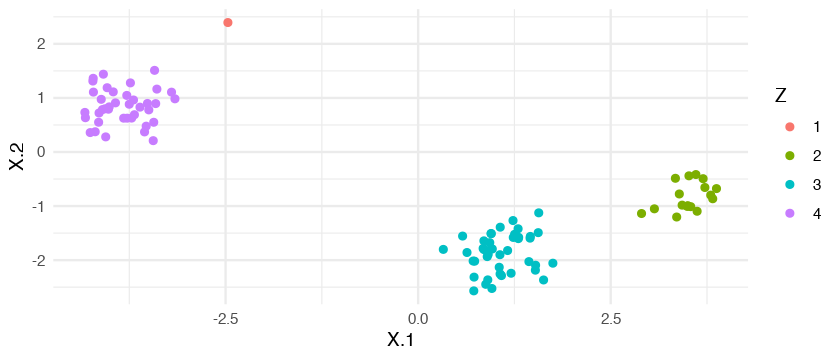

In [9]:
data.frame(X=X, Z=as.factor(Z)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

### Posterior inference using Gibbs sampling

We use *Gibbs sampling* for inference of the class assignments.

Initialization of cluster assignments: all to table 1. Hyperparameter $\alpha$ controls the probability of opening a new table

In [10]:
# initialization of the cluster assignments
K <- 1
zs <- rep(K, n)
alpha <- 5
tables <- n

Define the priors of the model. We set the covariances to be fixed.

In [11]:
mu.prior <- matrix(c(0, 0), ncol = 2)
sigma.prior <- diag(p)
q.prior <- solve(sigma.prior)

Base distribution $\mathcal{G}_0$:

In [12]:
sigma0 <- diag(p)
prec0 <- solve(sigma0)
mu0 <- rep(0, p)

To infer the posterior we would use the Gibbs sampler described above. Here, I am only interested in the most likely assignment, i.e. the map of $Z$.

In [75]:
for (iter in seq(100))
{
  for (i in seq(n))
  {
    # look at data x_i and romove its statistics from the clustering
    zi <- zs[i]
    tables[zi] <- tables[zi] - 1
    if (tables[zi] == 0) {
      K <- K - 1
      zs[zs > zi] <- zs[zs > zi] - 1
      tables <- tables[-zi]
      mu.prior <- mu.prior[-zi, ]
    }
    
    # compute posterior probabilitites P(z_i \mid z_-i, ...)
    no_i <- seq(n)[-i]
    probs <- sapply(seq(K), function(k) {
      crp <- sum(zs[no_i] == k) / (n + alpha - 1)
      lik <- mvtnorm::dmvnorm(X[i, ], mu.prior[k,], sigma.prior)
      crp * lik
    })
    
    # compute probability for opening up a new one
    crp <- alpha / (n + alpha - 1)
    lik <- mvtnorm::dmvnorm(X[i, ], mu0, sigma.prior + sigma0)
    probs <- c(probs, crp * lik)
    probs <- probs / sum(probs)
    
    # sample new z_i according to the conditional posterior above
    z_new <- which.max(probs)
    if (z_new > K) {
      K <- K + 1
      tables <- c(tables, 0)
      mu.prior <- rbind(mu.prior, mvtnorm::rmvnorm(1, mu0, sigma0))
    }
    zs[i] <- z_new        
    tables[z_new] <- tables[z_new] + 1
    
    # compute conditional posterior P(mu \mid ...)
    for(k in seq(K)) {
      Xk <- X[zs == k, ,drop=FALSE]
      lambda <- solve(q.prior + tables[k] * q.prior)
      nominator <- tables[k] * q.prior %*% apply(Xk, 2, mean)
      mu.prior[k, ] <- mvtnorm::rmvnorm(1, lambda %*% nominator, lambda)
    }
  }
}

Let's see if that worked out!

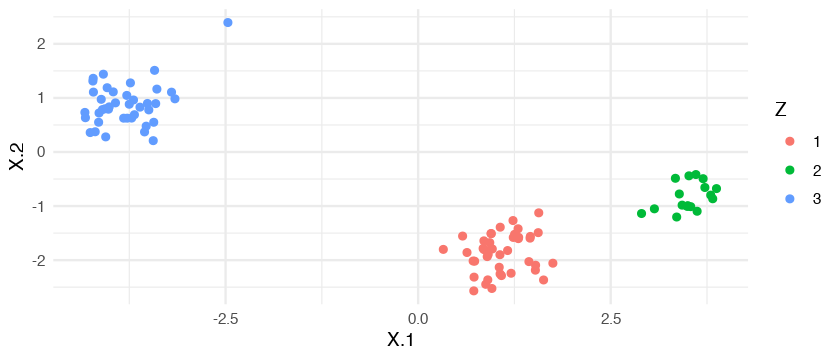

In [76]:
data.frame(X=X, Z=as.factor(zs)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

Cool, except for the lone guyu on top the clustering worked nicely.

## The stick-breaking construction

With the CRP with put a prior distribution on the possibly infinite number of class assignments. An alternative approach is to use *stick-breaking* construction. The advantage here is that we could use (a hack for) `Stan`, thus we don't need to implement the sampler ourselves. Let's give it a try.

### Data generating process

If we, instead of putting a CRP prior on the latent labels, put a prior on the possibly infinite sequence of mixing weights $\boldsymbol \pi$ we arrive at the *stick-breaking* construction. The hierarchical model now looks like this:

\begin{align*}
\nu_k &\sim \text{Beta}(1, \alpha) \\
\pi_k & = \nu_k  \prod_{j=1}^{k-1} (1 - \nu_j) \\
\boldsymbol \theta_k & \sim G_0 \\
\mathbf{x}_i & \sim \sum_k \pi_k P(\boldsymbol \theta_k)
\end{align*}

or alternatively if we want to introduce latent class labels:

\begin{align*}
\nu_k &\sim \text{Beta}(1, \alpha) \\
\pi_k & = \nu_k  \prod_{j=1}^{k-1} (1 - \nu_j) \\
\boldsymbol \theta_k & \sim G_0 \\
z_i & \sim \text{Discrete}(\boldsymbol \pi) \\
\mathbf{x}_i \mid z_i & \sim P(\boldsymbol \theta_{z_i})
\end{align*}

where $N_k$ is the number of customers at table $k$ and $\alpha$ some hyperparameter. The distribution of the mixing weights is sometimes denoted as

$$
\boldsymbol \pi \sim \text{GEM}(\alpha)
$$

In order to make the DPMM with stick-breaking work in Stan, we need to supply a maximum number of clusters $K$ from which we can choose. Setting $K=n$ would mean that we allow that every data point defines its own cluster. For the sake of the exercise I'll set it the maximum number of clusters to $10$. The hyperparameter $\alpha$ parameterizes the Beta-distribution which we use to sample stick lengths.

In [28]:
K <- 10
alpha <- 2

In [13]:
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘rstan’

The following object is masked from ‘package:coda’:

    traceplot



The model is a bit more verbos ein comparison to the finite case ([Bayesian mixture models](bayesian_mixture_models.ipynb)). We only need to add the stick breaking part in the `transformed parameters`, the rest stays the same. We again use the LKJ prior for the correlation matrix of the single components and set a fixed prior scale of $1$.

In [32]:
model.file <- "_models/dirichlet_process_mixture.stan"
cat(readLines(model.file), sep="\n")

data {
	int<lower=0> K;
	int<lower=0> n;
	int<lower=1> p;
	row_vector[p] x[n];
	real alpha;
}

parameters {    	
  	ordered[p] mu[K];
	cholesky_factor_corr[p] L;
	real <lower=0, upper=1> nu[K];
}

transformed parameters {
  simplex[K] pi;
  pi[1] = nu[1];
  for(j in 2:(K-1)) 
  {
      pi[j] = nu[j] * (1 - nu[j - 1]) * pi[j - 1] / nu[j - 1]; 
  }

  pi[K] = 1 - sum(pi[1:(K-1)]);
}

model {
  	real mix[K];

  	L ~ lkj_corr_cholesky(5);
  	nu ~ beta(1, alpha);	
	for (i in 1:K) 
	{
		mu[i] ~ normal(0, 5);
	}

  
  	for(i in 1:n) 
  	{
		for(k in 1:K) 
		{
			mix[k] = log(pi[k]) + multi_normal_cholesky_lpdf(x[i] | mu[k], L);
		}
		target += log_sum_exp(mix);
  	}
}


In [39]:
fit <- stan(model.file, data = list(K=K, n=n, x=X, p=p, alpha=alpha), iter = 10000, warmup = 1000, chains = 2)


SAMPLING FOR MODEL 'dirichlet_process_mixture' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.006115 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 61.15 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 355.935 seconds (Warm-up)
Chain 1:                132.033 seconds (Sampling)
Chain 1

In [40]:
fit

Inference for Stan model: dirichlet_process_mixture.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

            mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
mu[1,1]    -0.40    0.00 0.04   -0.48   -0.43   -0.40   -0.37   -0.33   746
mu[1,2]    -0.37    0.00 0.04   -0.45   -0.40   -0.37   -0.34   -0.30   916
mu[2,1]    -3.83    0.01 0.16   -4.13   -3.93   -3.84   -3.73   -3.54   497
mu[2,2]     0.84    0.01 0.16    0.54    0.73    0.84    0.94    1.14   544
mu[3,1]     1.31    0.00 0.06    1.17    1.26    1.31    1.35    1.42   542
mu[3,2]     1.36    0.00 0.06    1.24    1.31    1.35    1.40    1.48   781
mu[4,1]    -2.78    0.15 3.98  -11.52   -4.99   -2.69   -0.33    4.83   703
mu[4,2]     2.81    0.10 3.93   -4.74    0.27    2.57    5.17   11.16  1447
mu[5,1]    -2.80    0.27 4.45  -12.84   -5.31   -2.70   -0.02    5.92   282
mu[5,2]     2.98    0.13 3.97   -4.08    0.33    2.74    5.50   11.02

In [41]:
posterior <- extract(fit)

In [59]:
options(repr.fig.width=4, repr.plot.height=8)

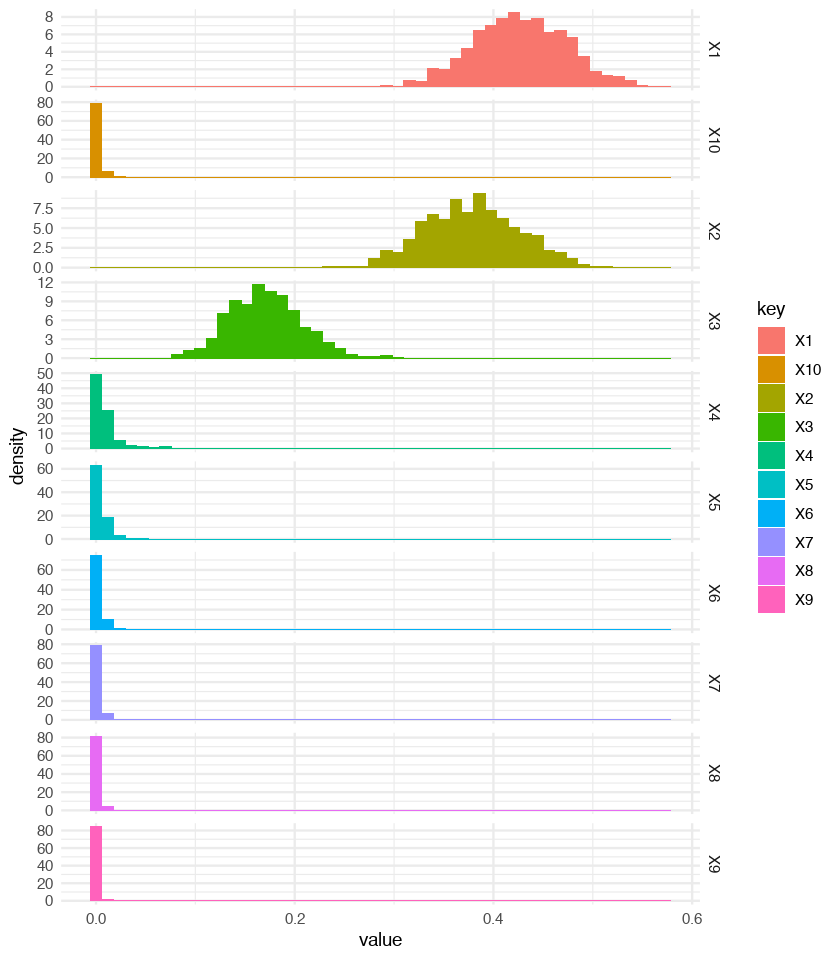

In [60]:
data.frame(posterior$pi)  %>% 
    tidyr::gather(key, value) %>%
    ggplot(aes(x = value, y = ..density.., fill=key), position="dodge") + 
    facet_grid(key ~ ., scales="free") +
    geom_histogram(bins=50) +
    theme_minimal()

From the plot above it looks as if Stan believes it's sufficient to use three components as the means of the mixing weights of the seven other components are fairly low or even zero. However, let's extract all means of the posterior means and assign each data point to a cluster.

In [80]:
post.mus <- do.call(
    "rbind", 
    lapply(
        1:10, function(i) apply(posterior$mu[,i,], 2, mean))
)

In [85]:
?set_names

In [91]:
probs <- purrr::map_dfc(seq(10), function(i) {
    mvtnorm::dmvnorm(X, post.mus[i,], diag(2))}) %>% 
    set_names(paste0("Z", seq(10)))

In [93]:
zs.stan <- apply(probs, 1, which.max)

And the final plot:

In [94]:
options(repr.fig.width=4, repr.plot.height=3)

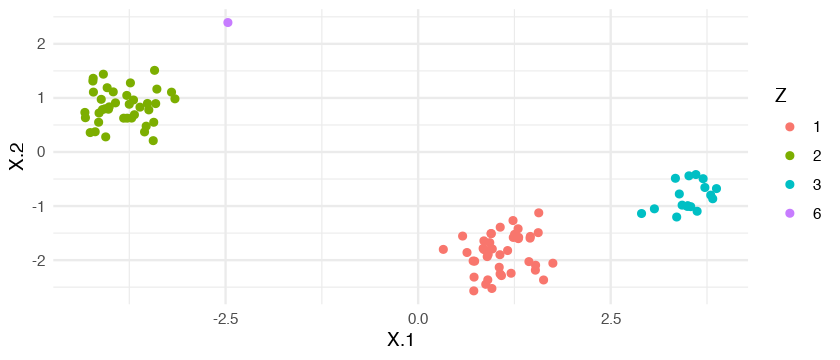

In [95]:
# initialization of the cluster assignments
data.frame(X=X, Z=as.factor(zs.stan)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

Cool, our small hack using Stan and stick-breaking worked even better than our CRP implementation. Here, we managed to give ever datum its correct label.